## Task 10: Plotting Bias-Variance Tradeoff and Correlation

In [2]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt
import glob


from algorithms import BMP
from data_generation import GaussianDataGenerator

In [3]:
pkl_files = glob.glob(os.path.join(os.getcwd(), "*.pkl"))
temp_pkl_file_name = pkl_files[0]
with open(temp_pkl_file_name, 'rb') as f:
    temp_data = pkl.load(f)[0]

In [7]:

temp_data_parameters = temp_data['parameters']
temp_data_log = temp_data['log'][0]


single_log_from_temp_data = temp_data_log[0]
single_trial_id = single_log_from_temp_data['trial']

train_X, test_X, train_y, test_y = single_log_from_temp_data['dataset']
K_coef_lst_mat = single_log_from_temp_data['K_coef_lst_mat']
K_final_coef_mat =  single_log_from_temp_data['K_final_coef_mat']

n = temp_data_parameters['n']
p = temp_data_parameters['p']
m = temp_data_parameters['m']
noise_level = single_log_from_temp_data['noise_level']

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, single_trial_id)
true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
real_coefficients = np.zeros(p)
real_coefficients[true_indices] = true_coefficients.flatten()

In [11]:
def return_cov_and_cor_for_single_k(coef_mat):
    cov_list = []
    cor_list = []
    for i in range(coef_mat.shape[0]):
        single_K_in_single_trial = coef_mat[i,:,:]
        single_estimation_cov_matrix = np.cov(single_K_in_single_trial)
        single_estimation_corr_matrix = np.corrcoef(single_K_in_single_trial)
        tril_idx = np.tril_indices(single_estimation_cov_matrix.shape[0], -1)
        cov_list.append(single_estimation_cov_matrix[tril_idx].mean())
        cor_list.append(single_estimation_corr_matrix[tril_idx].mean())
    return np.array(cov_list), np.array(cor_list)


def calculate_statistics_given_coefficients(
    K_final_coef_mat,
    K_coef_lst_mat,
    train_X,
    train_y,
    test_X,
    test_y,
    real_coefficients,
):
    single_estimation_variance = K_coef_lst_mat.var(axis=1).mean(axis=1)
    single_training_error = (((train_X @ K_final_coef_mat.T) - train_y)**2).mean(axis=0)
    single_testing_error = (((test_X @ K_final_coef_mat.T) - test_y)**2).mean(axis=0)
    single_estimation_bias = ((K_final_coef_mat - real_coefficients)**2).mean(axis=1)
    single_estimation_cov, single_estimation_corr = return_cov_and_cor_for_single_k(K_coef_lst_mat)
    return (
        single_estimation_variance,
        single_estimation_bias,
        single_estimation_cov,
        single_estimation_corr,
        single_training_error,
        single_testing_error,
    )
def summarize_one_log(temp_data_parameters,single_log_from_temp_data):
    single_trial_id = single_log_from_temp_data['trial']

    train_X, test_X, train_y, test_y = single_log_from_temp_data['dataset']
    K_coef_lst_mat = single_log_from_temp_data['K_coef_lst_mat']
    K_final_coef_mat =  single_log_from_temp_data['K_final_coef_mat']

    n = temp_data_parameters['n']
    p = temp_data_parameters['p']
    m = temp_data_parameters['m']
    noise_level = single_log_from_temp_data['noise_level']

    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, single_trial_id)
    true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
    real_coefficients = np.zeros(p)
    real_coefficients[true_indices] = true_coefficients.flatten()


    single_estimation_variance, single_estimation_bias, single_estimation_cov, single_estimation_corr, single_training_error, single_testing_error = calculate_statistics_given_coefficients(
        K_final_coef_mat,
        K_coef_lst_mat,
        train_X,
        train_y,
        test_X,
        test_y,
        real_coefficients,
    )

    indexed_K_final_coef_mat = K_final_coef_mat[:, true_indices]
    indexed_K_coef_lst_mat = K_coef_lst_mat[:, :, true_indices]
    indexed_train_X = train_X[:, true_indices]
    indexed_test_X = test_X[:, true_indices]
    indexed_train_y = train_y.copy()
    indexed_test_y = test_y.copy()
    indexed_real_coefficients = real_coefficients[true_indices]

    indexed_single_estimation_variance, indexed_single_estimation_bias, indexed_single_estimation_cov, indexed_single_estimation_corr, indexed_single_training_error, indexed_single_testing_error = calculate_statistics_given_coefficients(
        indexed_K_final_coef_mat,
        indexed_K_coef_lst_mat,
        indexed_train_X,
        indexed_train_y,
        indexed_test_X,
        indexed_test_y,
        indexed_real_coefficients,
    )

    return {
        'single_estimation_variance': single_estimation_variance,
        'single_estimation_bias': single_estimation_bias,
        'single_estimation_cov': single_estimation_cov,
        'single_estimation_corr': single_estimation_corr,
        'single_training_error': single_training_error,
        'single_testing_error': single_testing_error,
        'indexed_single_estimation_variance': indexed_single_estimation_variance,
        'indexed_single_estimation_bias': indexed_single_estimation_bias,
        'indexed_single_estimation_cov': indexed_single_estimation_cov,
        'indexed_single_estimation_corr': indexed_single_estimation_corr,
        'indexed_single_training_error': indexed_single_training_error,
        'indexed_single_testing_error': indexed_single_testing_error,
    }


In [34]:
temp_data_parameters = temp_data['parameters']
temp_data_log = temp_data['log'][0]


K_list = temp_data['parameters']['param_grid']['K']
trial_num = temp_data_parameters['trial_num']
estimation_variance = np.zeros((trial_num, len(K_list)))
estimation_bias = np.zeros((trial_num, len(K_list)))
estimation_cov = np.zeros((trial_num, len(K_list)))
estimation_corr = np.zeros((trial_num, len(K_list)))
training_error = np.zeros((trial_num, len(K_list)))
testing_error = np.zeros((trial_num, len(K_list)))
indexed_estimation_variance = np.zeros((trial_num, len(K_list)))
indexed_estimation_bias = np.zeros((trial_num, len(K_list)))
indexed_estimation_cov = np.zeros((trial_num, len(K_list)))
indexed_estimation_corr = np.zeros((trial_num, len(K_list)))
indexed_training_error = np.zeros((trial_num, len(K_list)))
indexed_testing_error = np.zeros((trial_num, len(K_list)))


for log_index in range(len(temp_data_log)):
    calculation_results = summarize_one_log(temp_data_parameters, temp_data_log[log_index])
    estimation_variance[log_index, :] = calculation_results['single_estimation_variance']
    estimation_bias[log_index, :] = calculation_results['single_estimation_bias']
    estimation_cov[log_index, :] = calculation_results['single_estimation_cov']
    estimation_corr[log_index, :] = calculation_results['single_estimation_corr']
    training_error[log_index, :] = calculation_results['single_training_error']
    testing_error[log_index, :] = calculation_results['single_testing_error']
    indexed_estimation_variance[log_index, :] = calculation_results['indexed_single_estimation_variance']
    indexed_estimation_bias[log_index, :] = calculation_results['indexed_single_estimation_bias']
    indexed_estimation_cov[log_index, :] = calculation_results['indexed_single_estimation_cov']
    indexed_estimation_corr[log_index, :] = calculation_results['indexed_single_estimation_corr']
    indexed_training_error[log_index, :] = calculation_results['indexed_single_training_error']
    indexed_testing_error[log_index, :] = calculation_results['indexed_single_testing_error']


/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zsr/opt/anaconda3/envs/summer2023/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [40]:
pkl_files = glob.glob(os.path.join(os.getcwd(), "*.pkl"))
temp_pkl_file_name = pkl_files[0]
with open(temp_pkl_file_name, 'rb') as f:
    temp_data = pkl.load(f)[0]

0.2

In [44]:
def viz_for_single_pkl_file(pkl_file_path):
    temp_data = None
    with open(pkl_file_path, 'rb') as f:
        temp_data = pkl.load(f)[0]
    n = temp_data_parameters['n']
    p = temp_data_parameters['p']
    m = temp_data_parameters['m']
    noise_level = temp_data_parameters['noise_level_lst'][0]
    print("Current Parameters Setting is:"+str(temp_data_parameters))

    # assuming *_mean variables are defined
    variable_names = ['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                    'training_error', 'testing_error', 'indexed_estimation_variance', 'indexed_estimation_bias',
                    'indexed_estimation_cov', 'indexed_estimation_corr', 'indexed_training_error', 'indexed_testing_error']

    # Calculate mean along the trial_num axis
    for var_name in variable_names:
        exec(f"{var_name}_mean = {var_name}.mean(axis=0)")

    # Create a new figure for each pair of variables
    for var_name in ['estimation_variance', 'estimation_bias', 'estimation_cov', 'estimation_corr', 
                    'training_error', 'testing_error']:
        plt.figure()
        
        indexed_var_name = 'indexed_' + var_name
        # Add lines
        plt.plot(K_list, eval(var_name + "_mean"), color='blue', label=var_name + ' Mean')
        plt.plot(K_list, eval(indexed_var_name + "_mean"), color='red', label=indexed_var_name + ' Mean')
        plt.title(var_name + f' vs. K at n = ' + str(n) + ', p = ' + str(p) + ', m = ' + str(m) + ', noise_level = ' + str(noise_level))
        # Add legend
        plt.legend()

    # Show the plot
    plt.show()


Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.9, 'atom_bag_percent': 0.8, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


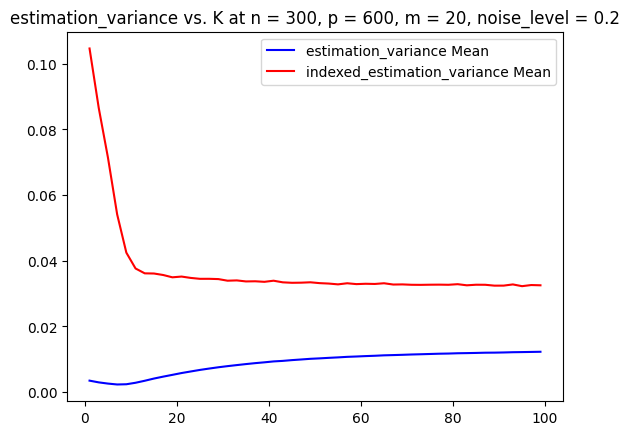

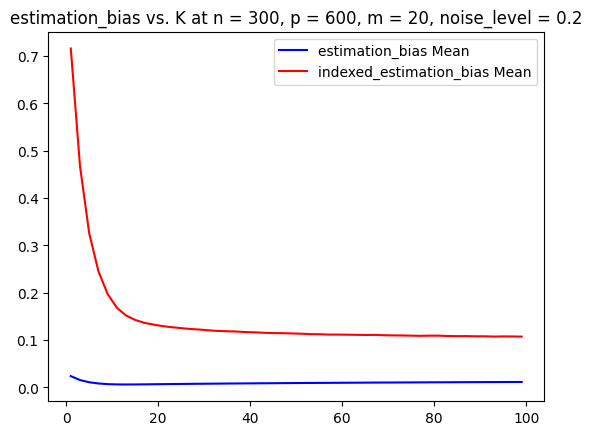

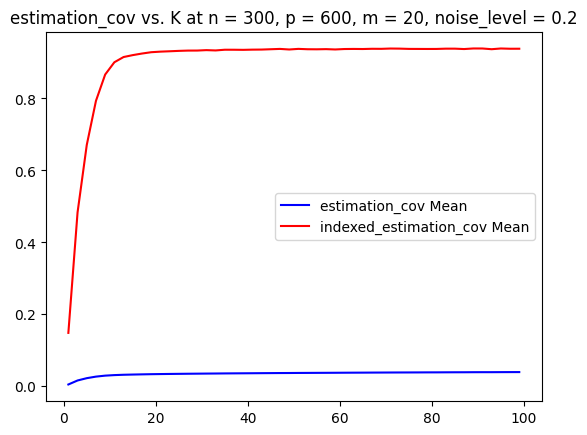

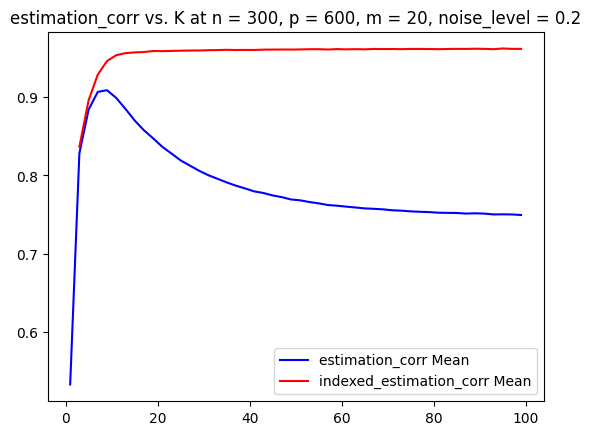

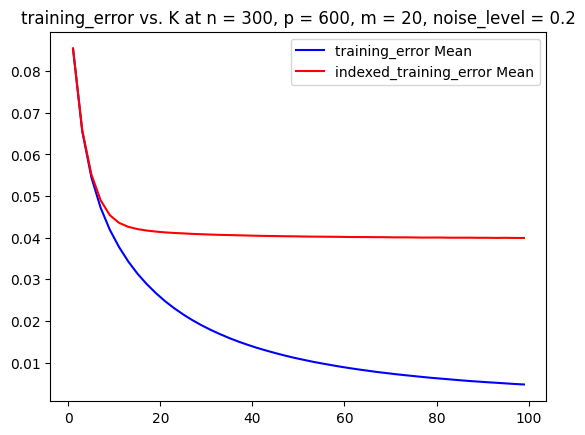

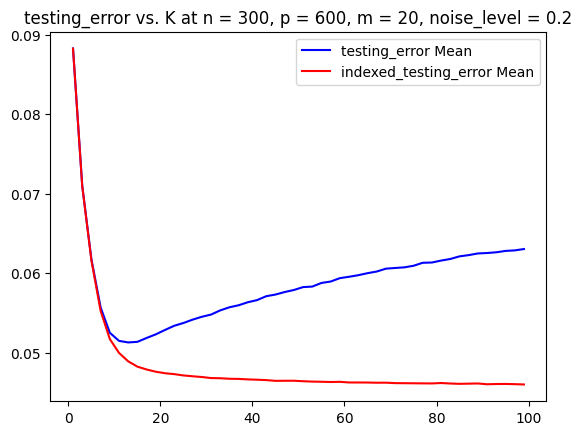

In [46]:
viz_for_single_pkl_file(pkl_files[0])

Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.9, 'atom_bag_percent': 0.8, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


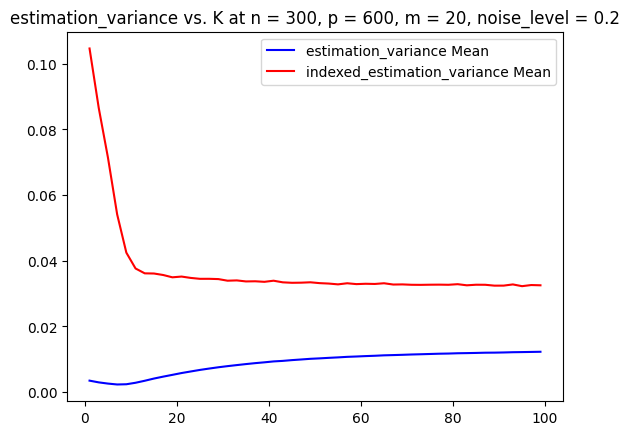

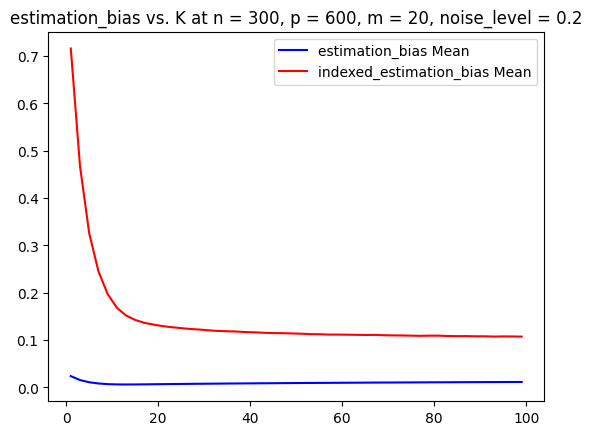

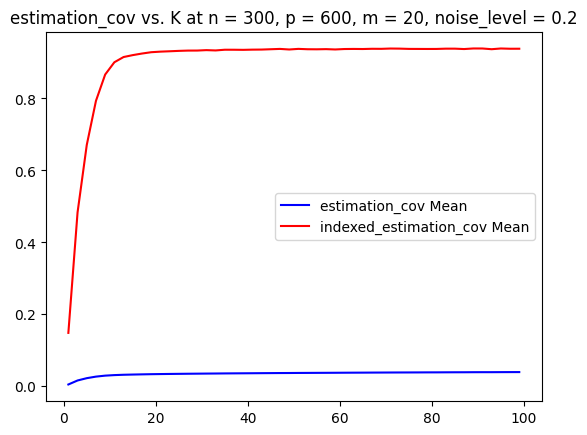

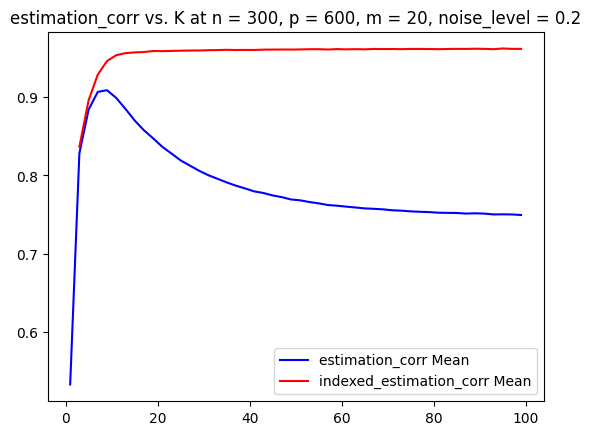

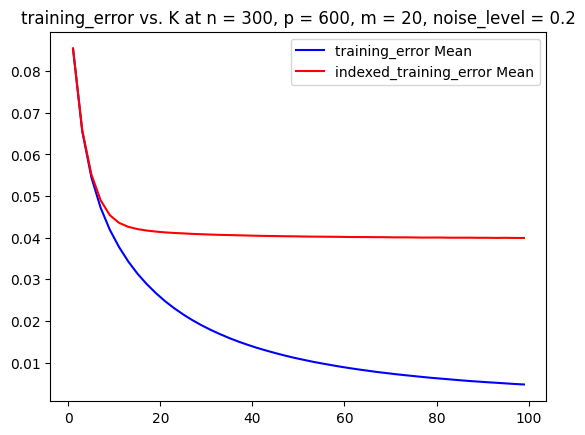

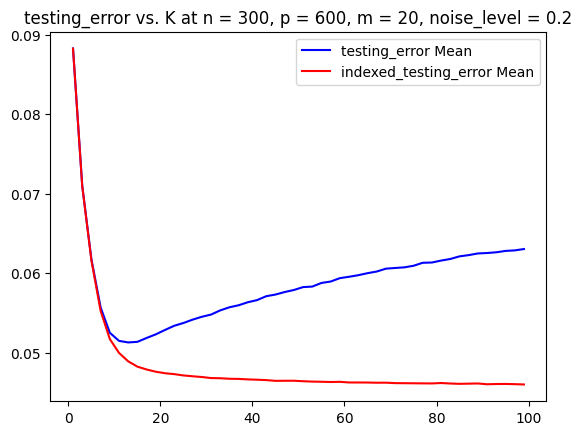

In [ ]:
viz_for_single_pkl_file(pkl_files[1])

Current Parameters Setting is:{'n': 300, 'p': 600, 'm': 20, 'noise_level_lst': [0.2], 'model_name': 'BMP', 'cv_num': 5, 'trial_num': 25, 'param_grid': {'K': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}, 'fixed_params': {'N_bag': 500, 'signal_bag_percent': 0.9, 'atom_bag_percent': 0.8, 'select_atom_percent': 0, 'replace_flag': False, 'agg_func': 'weight', 'ignore_warning': True, 'random_seed': None}}


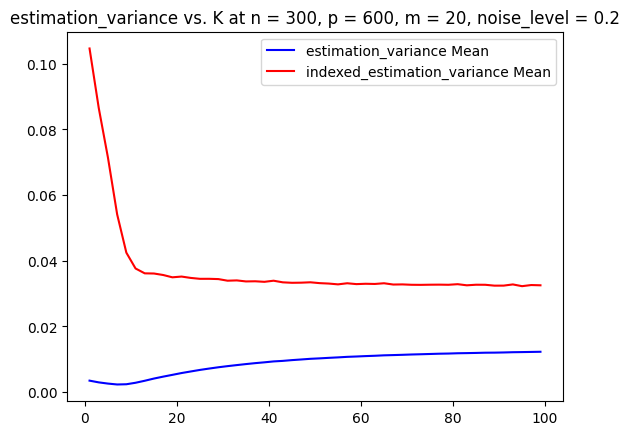

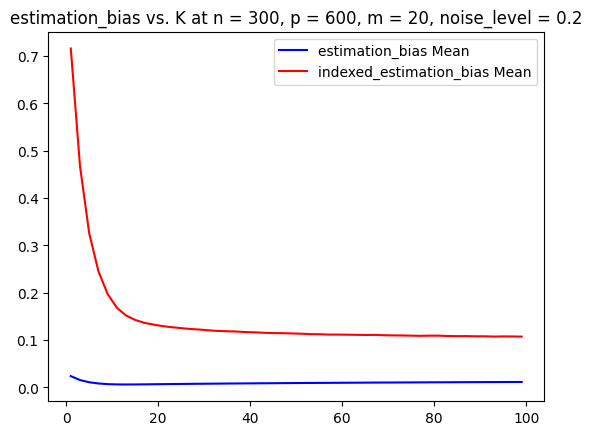

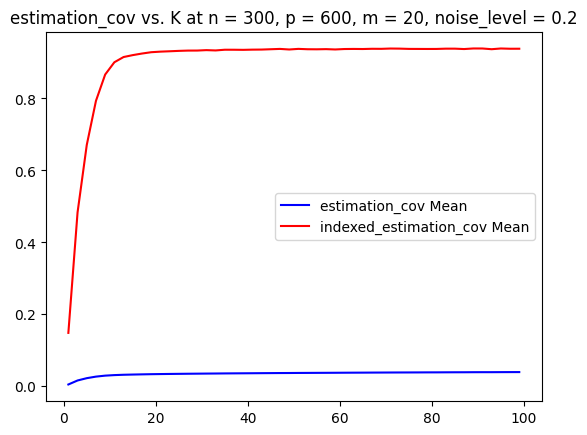

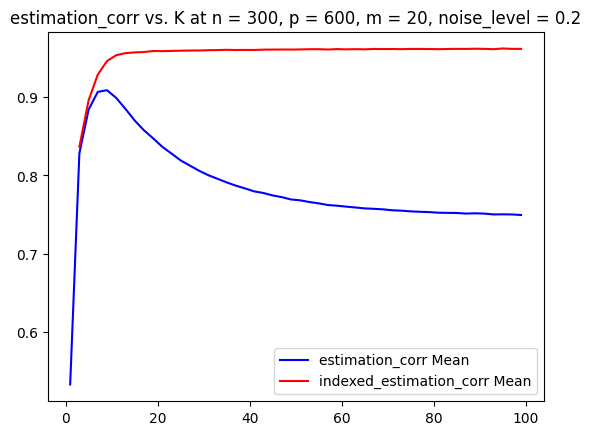

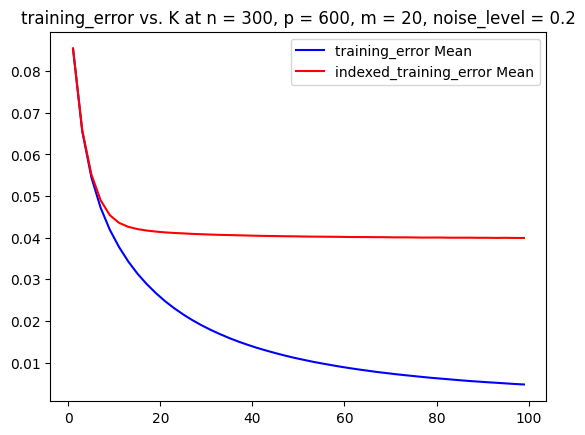

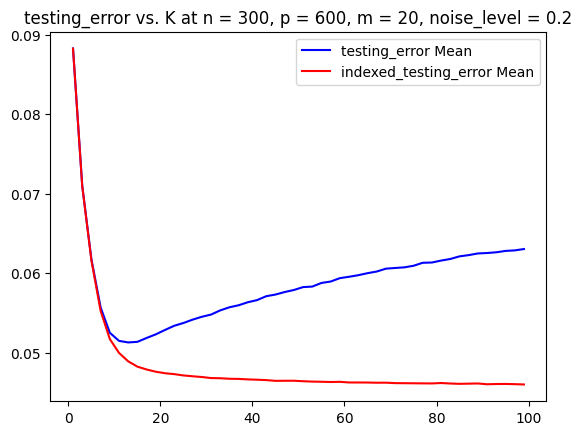

In [47]:
viz_for_single_pkl_file(pkl_files[2])